<a href="https://colab.research.google.com/github/tomo169/dogs-CNN/blob/main/ANM_Project_Tomislav_Maru%C5%A1i%C4%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikacija sorte pasa koristeći CNN
* Podaci su preuzeti s keggla: https://www.kaggle.com/competitions/dog-breed-identification/data
* Imamo Train i Teast foldere i .csv file s oznakama sorte psa po slici

In [ ]:
import torch
import pandas as pd
import os


## Priprema podataka

In [ ]:
#Provjeravamo je su li datoteke pravino učitane

from google.colab import drive
drive.mount('/content/drive')
import os

train_dir = "/content/drive/MyDrive/Dog_Vision/train"
test_dir = "/content/drive/MyDrive/Dog_Vision/test"
csv_path = "/content/drive/MyDrive/Dog_Vision/labels.csv"

print("Train Folder Exists:", os.path.exists(train_dir))
print("Test Folder Exists:", os.path.exists(test_dir))
print("CSV File Exists:", os.path.exists(csv_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train Folder Exists: True
Test Folder Exists: True
CSV File Exists: True


In [ ]:
import os
import shutil
import pandas as pd

# Sortiramo slike u zasebni folder tako da svaka sorta ima svoj folder
csv_path = "/content/drive/MyDrive/Dog_Vision/labels.csv"
train_dir = "/content/drive/MyDrive/Dog_Vision/train"
sorted_train_dir = "/content/drive/MyDrive/Dog_Vision/train_sorted"

df = pd.read_csv(csv_path)
df['id'] = df['id'].astype(str) + ".jpg"  # Dodajemo .jpg exstenziju

# Kreiranje foldera za sortu
for breed in df['breed'].unique():
    breed_folder = os.path.join(sorted_train_dir, breed)
    os.makedirs(breed_folder, exist_ok=True)

# Premještanje slika u njihov folder
for index, row in df.iterrows():
    image_name = row['id']
    breed = row['breed']

    src = os.path.join(train_dir, image_name)
    dest = os.path.join(sorted_train_dir, breed, image_name)

    if os.path.exists(src):
        shutil.move(src, dest)

print("✅ Images have been organized into breed folders!")


✅ Images have been organized into breed folders!


## Data augmentation
* Radimo različite transformacije nad slikama da bi kasnije model bolje učio

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Učitavamo sortirani folder
train_dir = "/content/drive/MyDrive/Dog_Vision/train_sorted"

# Transformacije
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)

# Provjeravamo broj klasa
num_classes = len(dataset.classes)
print(f"Total Images: {len(dataset)}, Number of Classes: {num_classes}")
print(f"Class Labels: {dataset.classes}")


Total Images: 10222, Number of Classes: 120
Class Labels: ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendae

In [ ]:
# Podjela podataka (80% Train, 20% Validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train Size: {len(train_dataset)}, Validation Size: {len(val_dataset)}")


Train Size: 8177, Validation Size: 2045


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

print("DataLoaders created successfully!")


DataLoaders created successfully!


## Definicija i treniranje modela

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

# Definicija CNN modela
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Tijekom treniranja CustomCNN() mrža je vraćala ovake rezultate
        # Epoch 1/50, Loss: 4.8424, Val Acc: 1.56%
        # Epoch 2/50, Loss: 4.7725, Val Acc: 1.17%
        # Epoch 3/50, Loss: 4.7569, Val Acc: 1.66%
        # Epoch 4/50, Loss: 4.7430, Val Acc: 2.64%
        # Epoch 5/50, Loss: 4.7302, Val Acc: 2.10%
        # Epoch 6/50, Loss: 4.7202, Val Acc: 2.35%
        # Epoch 7/50, Loss: 4.7155, Val Acc: 2.59%
        # Epoch 8/50, Loss: 4.7120, Val Acc: 2.54%
        # Epoch 9/50, Loss: 4.7037, Val Acc: 2.35%
        # Epoch 10/50, Loss: 4.6937, Val Acc: 2.74%
        # Epoch 11/50, Loss: 4.6766, Val Acc: 3.23%
# Obzirom da mreža loše uči u nastavku se koristi ResNet-50 predtrenirani model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CustomCNN(num_classes=num_classes).to(device)

# Učitavanje predtreniranog ResNet-50 modela
model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)


model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR every 10 epochs



In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    # Validation Step
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch 1/50, Loss: 4.7603, Val Acc: 2.64%
Epoch 2/50, Loss: 4.5698, Val Acc: 10.66%
Epoch 3/50, Loss: 4.3392, Val Acc: 20.39%
Epoch 4/50, Loss: 4.0880, Val Acc: 27.58%
Epoch 5/50, Loss: 3.8398, Val Acc: 31.34%
Epoch 6/50, Loss: 3.6097, Val Acc: 35.79%
Epoch 7/50, Loss: 3.4083, Val Acc: 39.51%
Epoch 8/50, Loss: 3.2010, Val Acc: 42.59%
Epoch 9/50, Loss: 3.0115, Val Acc: 45.53%
Epoch 10/50, Loss: 2.8492, Val Acc: 48.12%
Epoch 11/50, Loss: 2.7286, Val Acc: 49.49%
Epoch 12/50, Loss: 2.6430, Val Acc: 49.68%
Epoch 13/50, Loss: 2.5791, Val Acc: 51.78%
Epoch 14/50, Loss: 2.5146, Val Acc: 52.08%
Epoch 15/50, Loss: 2.4564, Val Acc: 52.96%
Epoch 16/50, Loss: 2.3924, Val Acc: 53.15%
Epoch 17/50, Loss: 2.3228, Val Acc: 53.45%
Epoch 18/50, Loss: 2.2775, Val Acc: 54.52%
Epoch 19/50, Loss: 2.2123, Val Acc: 55.35%
Epoch 20/50, Loss: 2.1723, Val Acc: 57.31%
Epoch 21/50, Loss: 2.1422, Val Acc: 57.41%
Epoch 22/50, Loss: 2.1153, Val Acc: 58.14%
Epoch 23/50, Loss: 2.0950, Val Acc: 59.46%
Epoch 24/50, Loss: 2.

## Evaulacija modela

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


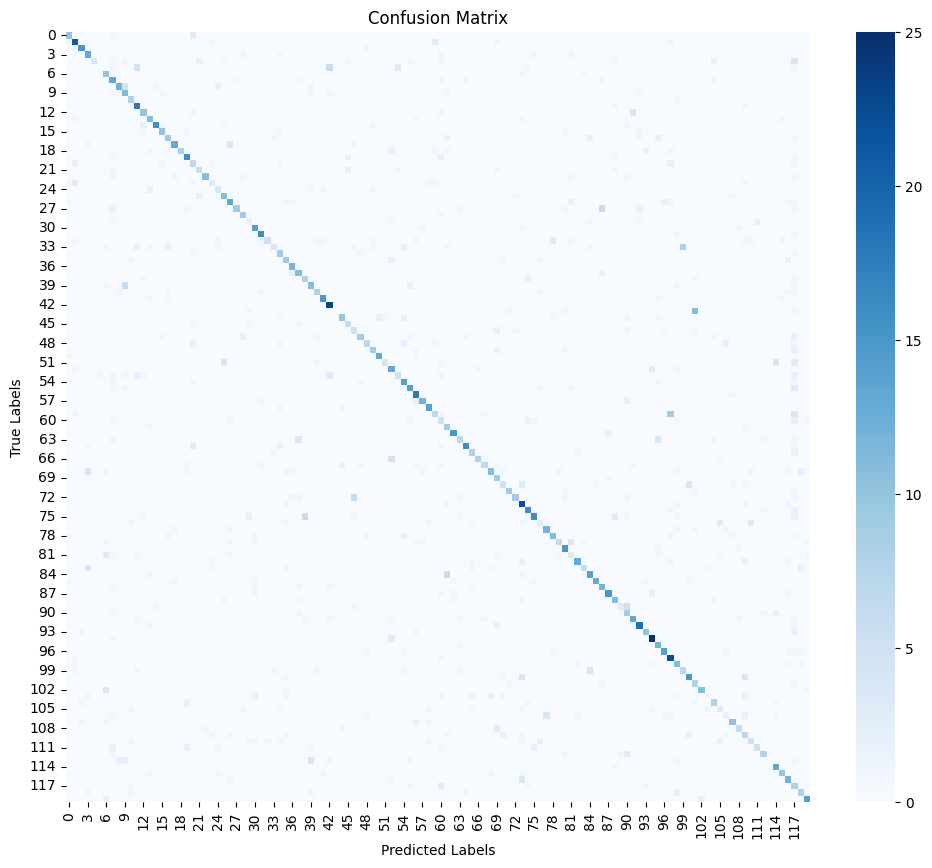

In [ ]:
# Kreiranje confusion matrice
conf_matrix = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Generiranje classification reporta za svaku od vrsta
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['breed'] = label_encoder.fit_transform(df['breed'])


print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


                                precision    recall  f1-score   support

                 affenpinscher       0.59      0.71      0.65        14
                  afghan_hound       0.64      0.75      0.69        28
           african_hunting_dog       0.83      0.94      0.88        16
                      airedale       0.52      0.72      0.60        18
american_staffordshire_terrier       1.00      0.21      0.35        19
                   appenzeller       0.00      0.00      0.00        17
            australian_terrier       0.42      0.83      0.56        12
                       basenji       0.36      0.68      0.47        19
                        basset       0.75      0.57      0.65        21
                        beagle       0.41      0.61      0.49        18
            bedlington_terrier       0.57      0.89      0.70         9
          bernese_mountain_dog       0.60      0.90      0.72        20
       black-and-tan_coonhound       0.62      0.62      0.62  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Spremanje Modela
torch.save(model.state_dict(), "best_model.pth")
print("Model saved successfully!")


Model saved successfully!


## Testiranje Modela

In [ ]:
# Učitavanje spremljenog modela
model.load_state_dict(torch.load("best_model.pth"))


<ipython-input-96-b8c6e9e16080>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import random
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Normalizacija testnih slika
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


all_test_images = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith(('.jpg', '.png', '.jpeg'))]

# Random biranje 10 slika iz test foldera
selected_test_images = random.sample(all_test_images, 10)

class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

test_dataset = TestDataset(selected_test_images, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"✅ Loaded {len(test_dataset)} test images successfully!")

✅ Loaded 10 test images successfully!


In [ ]:
import torch.nn.functional as F

model.eval()

# Predviđanja
predictions = []

with torch.no_grad():
    for images, img_paths in test_loader:
        images = images.to(device)

        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        max_prob, predicted = torch.max(probabilities, 1)

        predictions.append((img_paths[0], predicted.cpu().item(), max_prob.cpu().item()))

print("✅ Predictions completed for 10 images with confidence scores!")



✅ Predictions completed for 10 images with confidence scores!


In [ ]:
# Pretvaranje predviđenih oznaka u vrstu kojoj oznaka pripada
results = [(img_path, label_encoder.inverse_transform([pred])[0], confidence) for img_path, pred, confidence in predictions]

for img, breed, conf in results:
    print(f"📸 Image: {os.path.basename(img)} → Predicted Breed: {breed} (Confidence: {conf * 100:.2f}%)")



📸 Image: 01b09dccd56851eadb6ac3f2add3c822.jpg → Predicted Breed: walker_hound (Confidence: 14.39%)
📸 Image: 6a39904d4965e792a4330b5290dfb46f.jpg → Predicted Breed: bluetick (Confidence: 21.55%)
📸 Image: be92c0c3dd23697ee128fcc3dbdd3419.jpg → Predicted Breed: bloodhound (Confidence: 65.64%)
📸 Image: a1745679c2d02e886e26e6af58041676.jpg → Predicted Breed: walker_hound (Confidence: 16.00%)
📸 Image: fc774c01a474039d7fb7e53019997f4b.jpg → Predicted Breed: great_pyrenees (Confidence: 54.55%)
📸 Image: 42d9590a60f764850f55c94693e7566e.jpg → Predicted Breed: norwegian_elkhound (Confidence: 32.94%)
📸 Image: 39ae33e37489e73c1f5151a76f728aa3.jpg → Predicted Breed: rottweiler (Confidence: 26.11%)
📸 Image: aede98bbc83ac1479458ad747c980286.jpg → Predicted Breed: irish_setter (Confidence: 77.54%)
📸 Image: d1e2f9c636094acd34dde9f853835772.jpg → Predicted Breed: rhodesian_ridgeback (Confidence: 50.19%)
📸 Image: e1f25b73300a49b61a7690239fe37b38.jpg → Predicted Breed: schipperke (Confidence: 37.38%)


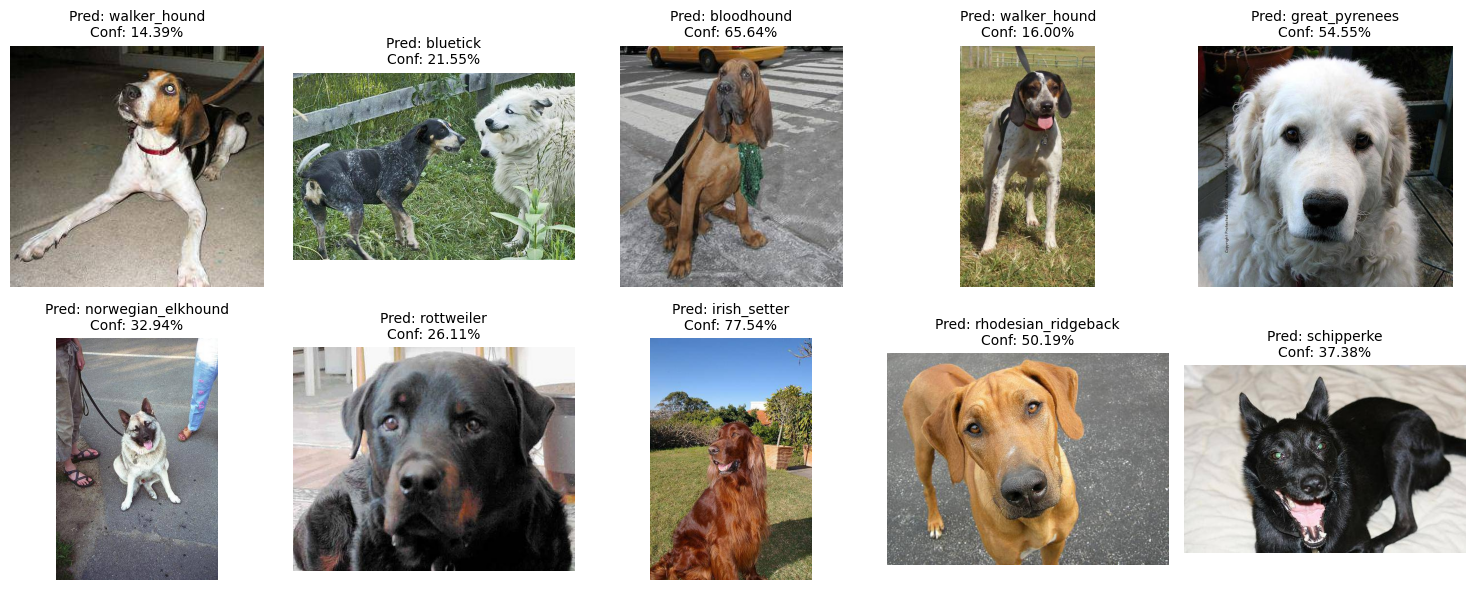

In [ ]:
import matplotlib.pyplot as plt

# Prikaz rezultata
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, (img_path, breed, conf) in enumerate(results):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {breed}\nConf: {conf * 100:.2f}%", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

